# Predicting Amazon Votes

In [1]:
'''
This notebook will build and test several models abilities to predict whether a review
was helpful or not

The problem is defined as follows: 
It is a binary classification problemm, essentially, the model will predict 1 if the review (and other features) 
associated to that product was helpful, 0 otherwise.

It will be trained on select numerical features which were generated during the data preprocessing segment
(refer to the amazon_data.ipynb notebook). The label to train the model to predict on will be identified using the
vote column values:
    If there is a vote > 0 for a particular review for a product, then the label will be 1 (essentially, someone found it
    useful of a review). Otherwise the label will be 0, essentially, no one found it as a useful review.
    
For a first step, I will explore the Logistic Regression and Random Forest Classifier models for this tasks. They were chosen 
because of their overall popularity and performance for these types of tasks. I will assess the accuracy and the accuracy on a 
validation set associated to both models and choose the best model for the rest API. 
'''

import pandas as pd
import numpy as np
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [2]:
# constants
base_path = os.path.expanduser('~') + '/'
data_path = 'Downloads/video_game_data_preprocessed.csv'

features_cols = [
    'price', 'overall', 'main_cat', 'verified', 'valid_image', 'review_year', 'time_since_review',
    'review_wc', 'summary_wc', 'title_wc', 'description_count',
    'similar_item_present', 'recommended_item_counts', 'count_also_bought',
    'image_present', 'best_rank', 'vote'
]

## Import Data

In [3]:
d = pd.read_csv(base_path + data_path, low_memory = False, nrows=250000)

## Preprocess Data

In [4]:
feat_df = d[features_cols].dropna().copy()

In [5]:
def generate_label(row):
    '''
    This function will return a label of 1 if there is a vote for a review which is greater than 0,
    otherwise it will return a 0.
        1 : The review was helpfull 
        2 : The review was not helpfull
    '''
    
    if int(row) > 0:
        return 1
    return 0

In [6]:
%time feat_df['label'] = feat_df['vote'].apply(lambda x : generate_label(x))

CPU times: user 219 ms, sys: 6.16 ms, total: 225 ms
Wall time: 37.7 ms


## Encode Categorical Values

In [7]:
encoded_cats = pd.get_dummies(feat_df.main_cat, prefix='category')

In [8]:
feat_df = pd.concat([encoded_cats, feat_df], axis = 1).drop(columns = ['main_cat', 'vote'])

## Create Validation Set

In [9]:
validation_df = feat_df.sample(50000)

In [10]:
feat_df = feat_df[~feat_df.index.isin(validation_df.index.values)]


## Modelling

In [11]:
X = feat_df.drop(columns = ['label']).values
y = feat_df['label'].values

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X ,y ,test_size = 0.3) 

### Logistic Regression

In [13]:
%%time 
lr = LogisticRegression(max_iter = 1000)  
reg = lr.fit(x_train,y_train)

CPU times: user 3.79 s, sys: 44.4 ms, total: 3.84 s
Wall time: 657 ms


In [14]:
pred_train = reg.predict(x_train)  
pred_test = reg.predict(x_test)

In [15]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      6751
           1       0.60      0.31      0.41      1916

    accuracy                           0.80      8667
   macro avg       0.71      0.63      0.64      8667
weighted avg       0.78      0.80      0.78      8667



In [16]:
lr_val = validation_df.copy()
lr_feats = lr_val.drop(columns = ['label']).values
lr_val['pred'] = reg.predict(lr_feats)

In [17]:
true_positives = lr_val[lr_val['label'] == lr_val['pred']].shape[0]
total_sample = lr_val.shape[0]
accuracy = true_positives / total_sample
print(accuracy * 100)

80.784


### Random Forest

In [18]:
%%time
rf = RandomForestClassifier()
rf_clf = rf.fit(x_train, y_train)

CPU times: user 1.77 s, sys: 26.8 ms, total: 1.8 s
Wall time: 1.81 s


In [19]:
pred_train_rf = rf_clf.predict(x_train)  
pred_test_rf = rf_clf.predict(x_test)

In [20]:
print(classification_report(y_test, pred_test_rf))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6751
           1       0.75      0.60      0.66      1916

    accuracy                           0.87      8667
   macro avg       0.82      0.77      0.79      8667
weighted avg       0.86      0.87      0.86      8667



In [21]:
rf_val = validation_df.copy()
rf_feats = rf_val.drop(columns = ['label']).values
rf_val['pred'] = rf_clf.predict(rf_feats)

In [22]:
true_positives = rf_val[rf_val['label'] == rf_val['pred']].shape[0]
total_sample = rf_val.shape[0]
accuracy = true_positives / total_sample
print(accuracy * 100)

86.744


### Feature Importance

In [35]:
from sklearn.feature_selection import SelectFromModel

In [43]:
# features that have an importance of more than 0.15
sfm = SelectFromModel(rf_clf, threshold=0.05)

# Train the selector
sfm.fit(x_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [44]:
sfm.get_support()

array([False, False, False, False, False,  True, False, False, False,
        True,  True,  True,  True, False,  True, False,  True,  True,
       False,  True])

In [46]:
feat_df.drop(columns = ['label']).columns[(sfm.get_support())]

Index(['price', 'review_year', 'time_since_review', 'review_wc', 'summary_wc',
       'description_count', 'recommended_item_counts', 'count_also_bought',
       'best_rank'],
      dtype='object')

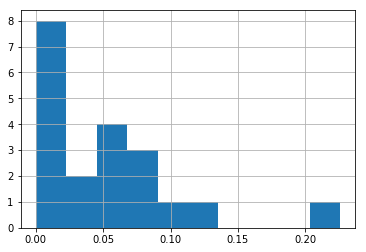

In [50]:
pd.Series(sfm.estimator_.feature_importances_.ravel()).hist()

## Save Results

In [23]:
model_path = '../models/random_forest_clf_model_vg.sav'
pickle.dump(rf_clf, open(model_path, 'wb'))